In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
df=pd.read_excel('GUJ_2G_Traffic_Day.xlsx')

In [3]:
df.shape

(518, 2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 518 non-null    datetime64[ns]
 1   2G_Traffic_GUJ_kErl  516 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.2 KB


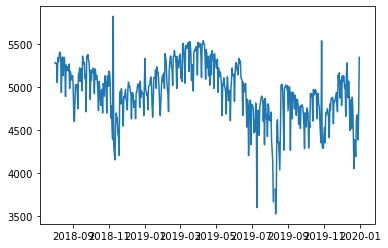

In [4]:
df.head(2)
df.info()
plt.plot(df['Date'],df['2G_Traffic_GUJ_kErl'])
plt.show()

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.index.freq = 'D'
train, test = df.iloc[:362, 0], df.iloc[362:, 0]
test.head()

Date
2019-07-29    4804.39541
2019-07-30    4782.75873
2019-07-31    4617.06801
2019-08-01    4647.32489
2019-08-02    4602.48772
Freq: D, Name: 2G_Traffic_GUJ_kErl, dtype: float64

In [6]:
from pandas.tseries.frequencies import to_offset
from statsmodels.base.data import PandasData
import statsmodels.base.model as base
import statsmodels.base.wrapper as wrap
from statsmodels.tools.sm_exceptions import ValueWarning

model = ExponentialSmoothing(train, 
                             trend='add', 
                             damped=False, 
                             seasonal='add', 
                             seasonal_periods=120).fit()

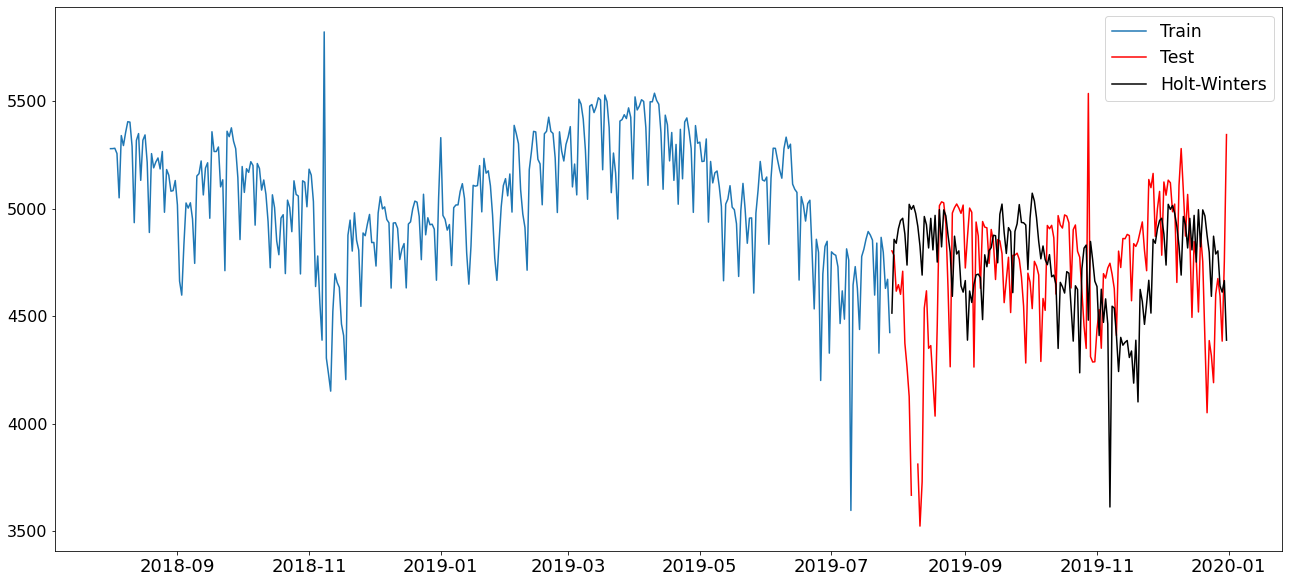

In [7]:
holt_pred = model.predict(start=test.index[0], end=test.index[-1])
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(holt_pred.index, holt_pred, label='Holt-Winters', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [8]:
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")

In [9]:
def find_best_sarima(train, eval_metric):
    
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 3) for x in list(itertools.product(p, d, q))]

    counter = 0
    myDict = {}
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                counter += 1
                mod = sm.tsa.statespace.SARIMAX(train,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                myDict[counter] = [results.aic, results.bic, param, param_seasonal]

            except:
                continue
                
    dict_to_df = pd.DataFrame.from_dict(myDict,orient='index')
    
    if eval_metric == 'aic':
        best_run = dict_to_df[dict_to_df[0] == dict_to_df[0].min()].index.values
        best_run = best_run[0]
    elif eval_metric == 'bic':
        best_run = dict_to_df[dict_to_df[1] == dict_to_df[1].min()].index.values
        best_run = best_run[0]
            
    model = sm.tsa.statespace.SARIMAX(train,
                                      order=myDict[best_run][2],
                                      seasonal_order=myDict[best_run][3],
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit()
    
    best_model = {'model':model, 
                  'aic':model.aic,
                  'bic':model.bic,
                  'order':myDict[best_run][2], 
                  'seasonal_order':myDict[best_run][3]}
    
    return best_model

In [ ]:
best = find_best_sarima(train, 'aic')

In [ ]:
sarima_pred = best['model'].predict(start=test.index[0], end=test.index[-1], dynamic=True)

In [ ]:
plt.figure(figsize=(22, 10))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test', color='r')
plt.plot(sarima_pred.index, sarima_pred, label='SARIMA', color='k')
plt.legend(loc='best', fontsize='xx-large')
plt.show()